In [1]:
import torch
import os
import numpy as np
import diffusers
import random
import pickle

from PIL import Image
from tqdm.auto import tqdm
from diffusers.pipelines.stable_diffusion import StableDiffusionPipeline
from diffusers import DDIMScheduler

import transformers
from transformers import CLIPTextModel, CLIPTokenizer
import torch.nn.functional as F
from torchvision import transforms

token = ## Put your access token here ##
device= "cuda:0"

/home/nsml/anaconda3/envs/ldm2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pipe = diffusers.StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        safety_checker=None,
        variant="fp16",
        cache_dir='./models/diffusers/',
        use_auth_token=token).to(device)

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler.set_timesteps(50)
timesteps = pipe.scheduler.timesteps
sp_sz = pipe.unet.sample_size
bsz = 4

Loading pipeline components...: 100%|██████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.16s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [3]:
def mod_forward(self, hidden_states, encoder_hidden_states=None, attention_mask=None, temb=None):

    residual = hidden_states

    if self.spatial_norm is not None:
        hidden_states = self.spatial_norm(hidden_states, temb)

    input_ndim = hidden_states.ndim

    if input_ndim == 4:
        batch_size, channel, height, width = hidden_states.shape
        hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

    batch_size, sequence_length, _ = (hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape)
    attention_mask = self.prepare_attention_mask(attention_mask, sequence_length, batch_size)

    if self.group_norm is not None:
        hidden_states = self.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

    query = self.to_q(hidden_states)

    sa_ = True if encoder_hidden_states is None else False
    encoder_hidden_states = text_cond if encoder_hidden_states is not None else hidden_states
    if self.norm_cross:
        encoder_hidden_states = self.norm_encoder_hidden_states(encoder_hidden_states)

    key = self.to_k(encoder_hidden_states)
    value = self.to_v(encoder_hidden_states)

    query = self.head_to_batch_dim(query)
    key = self.head_to_batch_dim(key)
    value = self.head_to_batch_dim(value)
    
    #################################################
    global COUNT
    
    if COUNT/32 < 50*reg_part:
        
        dtype = query.dtype
        if self.upcast_attention:
            query = query.float()
            key = key.float()
            
        sim = torch.baddbmm(torch.empty(query.shape[0], query.shape[1], key.shape[1], 
                                        dtype=query.dtype, device=query.device),
                            query, key.transpose(-1, -2), beta=0, alpha=self.scale)
        
        treg = torch.pow(timesteps[COUNT//32]/1000, 5)
        
        ## reg at self-attn
        if sa_:
            min_value = sim[int(sim.size(0)/2):].min(-1)[0].unsqueeze(-1)
            max_value = sim[int(sim.size(0)/2):].max(-1)[0].unsqueeze(-1)  
            mask = sreg_maps[sim.size(1)].repeat(self.heads,1,1)
            size_reg = reg_sizes[sim.size(1)].repeat(self.heads,1,1)
            
            sim[int(sim.size(0)/2):] += (mask>0)*size_reg*sreg*treg*(max_value-sim[int(sim.size(0)/2):])
            sim[int(sim.size(0)/2):] -= ~(mask>0)*size_reg*sreg*treg*(sim[int(sim.size(0)/2):]-min_value)
            
            
        ## reg at cross-attn
        else:
            min_value = sim[int(sim.size(0)/2):].min(-1)[0].unsqueeze(-1)
            max_value = sim[int(sim.size(0)/2):].max(-1)[0].unsqueeze(-1)  
            mask = creg_maps[sim.size(1)].repeat(self.heads,1,1)
            size_reg = reg_sizes[sim.size(1)].repeat(self.heads,1,1)
            
            sim[int(sim.size(0)/2):] += (mask>0)*size_reg*creg*treg*(max_value-sim[int(sim.size(0)/2):])
            sim[int(sim.size(0)/2):] -= ~(mask>0)*size_reg*creg*treg*(sim[int(sim.size(0)/2):]-min_value)
            
        attention_probs = sim.softmax(dim=-1)
        attention_probs = attention_probs.to(dtype)
            
    else:
        attention_probs = self.get_attention_scores(query, key, attention_mask)
           
    COUNT += 1
    #################################################        

    hidden_states = torch.bmm(attention_probs, value)
    hidden_states = self.batch_to_head_dim(hidden_states)

    # linear proj
    hidden_states = self.to_out[0](hidden_states)
    # dropout
    hidden_states = self.to_out[1](hidden_states)

    if input_ndim == 4:
        hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

    if self.residual_connection:
        hidden_states = hidden_states + residual

    hidden_states = hidden_states / self.rescale_output_factor

    return hidden_states

In [4]:
for _module in pipe.unet.modules():
    if _module.__class__.__name__ == "Attention":
        _module.__class__.__call__ = mod_forward

In [5]:
with open('./dataset/valset.pkl', 'rb') as f:
    dataset = pickle.load(f)
layout_img_root = './dataset/valset_layout/'

# with open('./dataset/testset.pkl', 'rb') as f:
#     dataset = pickle.load(f)
# layout_img_root = './dataset/testset_layout/'

A painting of a couple holding a yellow umbrella in a street on a rainy night. The woman is wearing a white dress and the man is wearing a blue suit.
a street on a rainy night
the man is wearing a blue suit
a yellow umbrella
the woman is wearing a white dress


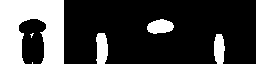

In [6]:
idx = 5
layout_img_path = layout_img_root+str(idx)+'.png'
prompts = [dataset[idx]['textual_condition']] + dataset[idx]['segment_descriptions']

############
text_input = pipe.tokenizer(prompts, padding="max_length", return_length=True, return_overflowing_tokens=False, 
                            max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt")
cond_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]

uncond_input = pipe.tokenizer([""]*bsz, padding="max_length", max_length=pipe.tokenizer.model_max_length,
                              truncation=True, return_tensors="pt")
uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

for i in range(1,len(prompts)):
    wlen = text_input['length'][i] - 2
    widx = text_input['input_ids'][i][1:1+wlen]
    for j in range(77):
        if (text_input['input_ids'][0][j:j+wlen] == widx).sum() == wlen:
            break

############
layout_img_ = np.asarray(Image.open(layout_img_path).resize([sp_sz*8,sp_sz*8]))[:,:,:3]
unique, counts = np.unique(np.reshape(layout_img_,(-1,3)), axis=0, return_counts=True)
sorted_idx = np.argsort(-counts)

layouts_ = []

for i in range(len(prompts)-1):
    if (unique[sorted_idx[i]] == [0, 0, 0]).all() or (unique[sorted_idx[i]] == [255, 255, 255]).all():
        layouts_ = [((layout_img_ == unique[sorted_idx[i]]).sum(-1)==3).astype(np.uint8)] + layouts_
    else:
        layouts_.append(((layout_img_ == unique[sorted_idx[i]]).sum(-1)==3).astype(np.uint8))
        
layouts = [torch.FloatTensor(l).unsqueeze(0).unsqueeze(0).cuda() for l in layouts_]
layouts = F.interpolate(torch.cat(layouts),(sp_sz,sp_sz),mode='nearest')

############
print('\n'.join(prompts))
Image.fromarray(np.concatenate([255*_.squeeze().cpu().numpy() for _ in layouts], 1).astype(np.uint8))

In [7]:
###########################
###### prep for sreg ###### 
###########################
sreg_maps = {}
reg_sizes = {}
for r in range(4):
    res = int(sp_sz/np.power(2,r))
    layouts_s = F.interpolate(layouts,(res, res),mode='nearest')
    layouts_s = (layouts_s.view(layouts_s.size(0),1,-1)*layouts_s.view(layouts_s.size(0),-1,1)).sum(0).unsqueeze(0).repeat(bsz,1,1)
    reg_sizes[np.power(res, 2)] = 1-1.*layouts_s.sum(-1, keepdim=True)/(np.power(res, 2))
    sreg_maps[np.power(res, 2)] = layouts_s
    
    
###########################
###### prep for creg ######
###########################
pww_maps = torch.zeros(1, 77, sp_sz, sp_sz).to(device)
for i in range(1,len(prompts)):
    wlen = text_input['length'][i] - 2
    widx = text_input['input_ids'][i][1:1+wlen]
    for j in range(77):
        if (text_input['input_ids'][0][j:j+wlen] == widx).sum() == wlen:
            pww_maps[:,j:j+wlen,:,:] = layouts[i-1:i]
            cond_embeddings[0][j:j+wlen] = cond_embeddings[i][1:1+wlen]
            print(prompts[i], i, '-th segment is handled.')
            break
            
creg_maps = {}
for r in range(4):
    res = int(sp_sz/np.power(2,r))
    layout_c = F.interpolate(pww_maps,(res,res),mode='nearest').view(1,77,-1).permute(0,2,1).repeat(bsz,1,1)
    creg_maps[np.power(res, 2)] = layout_c

    
###########################    
#### prep for text_emb ####
###########################
text_cond = torch.cat([uncond_embeddings, cond_embeddings[:1].repeat(bsz,1,1)])

a street on a rainy night 1 -th segment is handled.
the man is wearing a blue suit 2 -th segment is handled.
a yellow umbrella 3 -th segment is handled.
the woman is wearing a white dress 4 -th segment is handled.


In [8]:
reg_part = .3
sreg = .3
creg = 1.

COUNT = 0

with torch.no_grad():
#     latents = torch.randn(bsz,4,sp_sz,sp_sz).to(device)
    latents = torch.randn(bsz,4,sp_sz,sp_sz, generator=torch.Generator().manual_seed(1)).to(device) 
    image = pipe(prompts[:1]*bsz, latents=latents).images

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.27it/s]


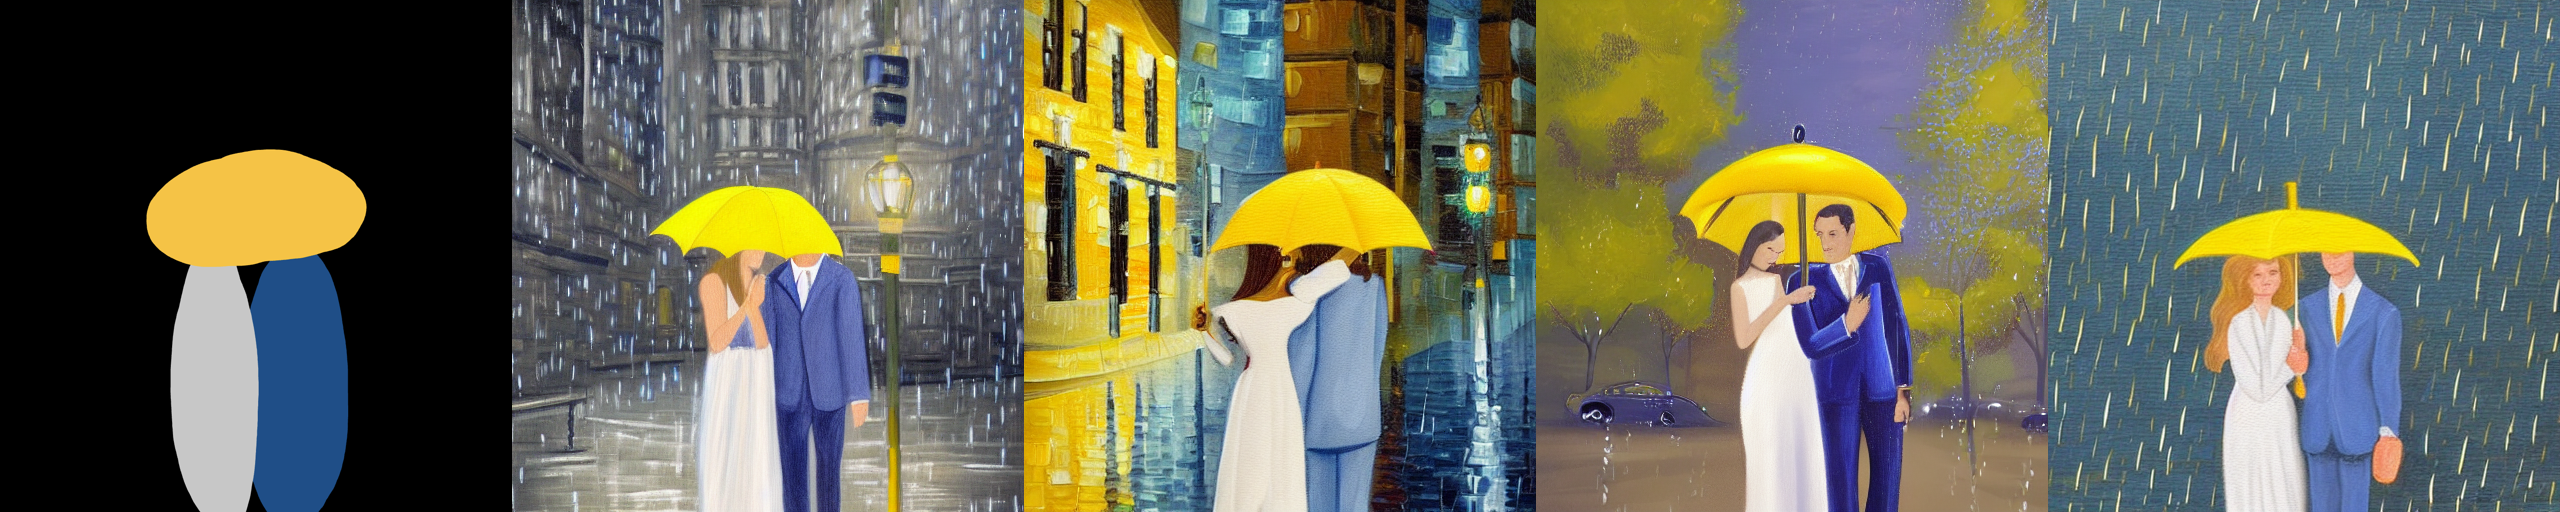

In [9]:
Image.fromarray(np.concatenate([layout_img_.astype(np.uint8)]+[np.asarray(image[i]) for i in range(len(image))], 1))